In [10]:
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from ast import literal_eval
import os
import sys
import gc
import glob

In [11]:
# Select the GPU to run on
cuda = torch.device('cuda:1')
torch.cuda.set_device(1)

In [12]:
df_rmsds = pd.read_csv('../../data/rmsd_dataset.csv')

pdb_id_1 = '5fog_d'
pdb_id_2 = '1c3h_a'
pdb_id_3 = '1bht_a'
pdb_id_4 = '5l8r_2'
pdb_id_5 = '1a2x_a'
pdb_id_6 = '6s3t_a'
pdb_id_7 = '1a9p_a'
pdb_id_8 = '1ku2_a'
pdb_id_9 = '3fhz_d'


def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def normalise(data):
    data = np.reshape(data, (1, len(data)))
    data = data - np.mean(data)
    data = data / np.std(data)
    return data


def display_output_heatmap(data, title):
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(24, 8))
    sns.heatmap(data, cmap='viridis', square=True, cbar=False, xticklabels=10, yticklabels=4)
    plt.title(title)
    plt.show()

(128, 171)


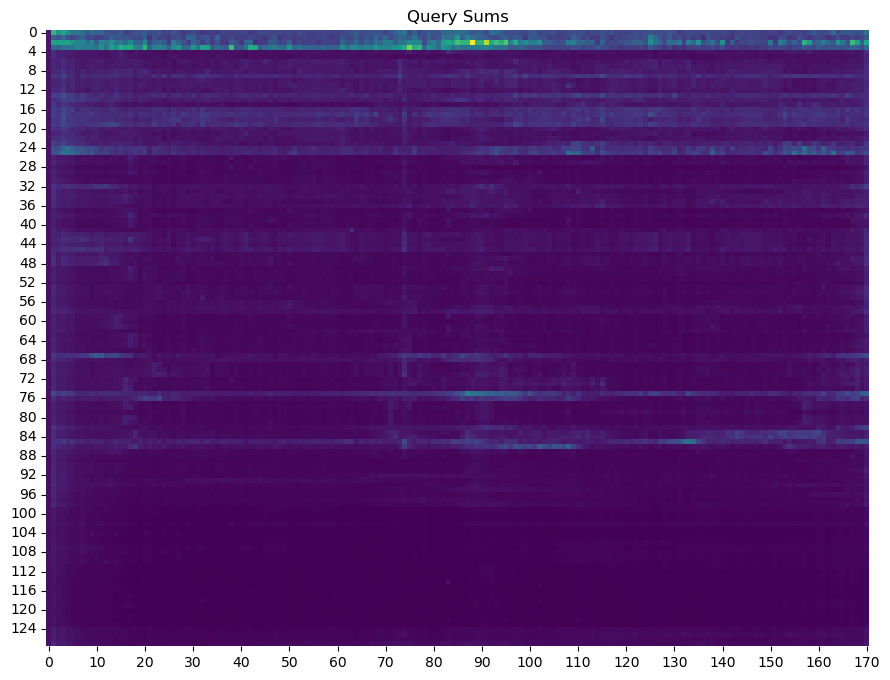

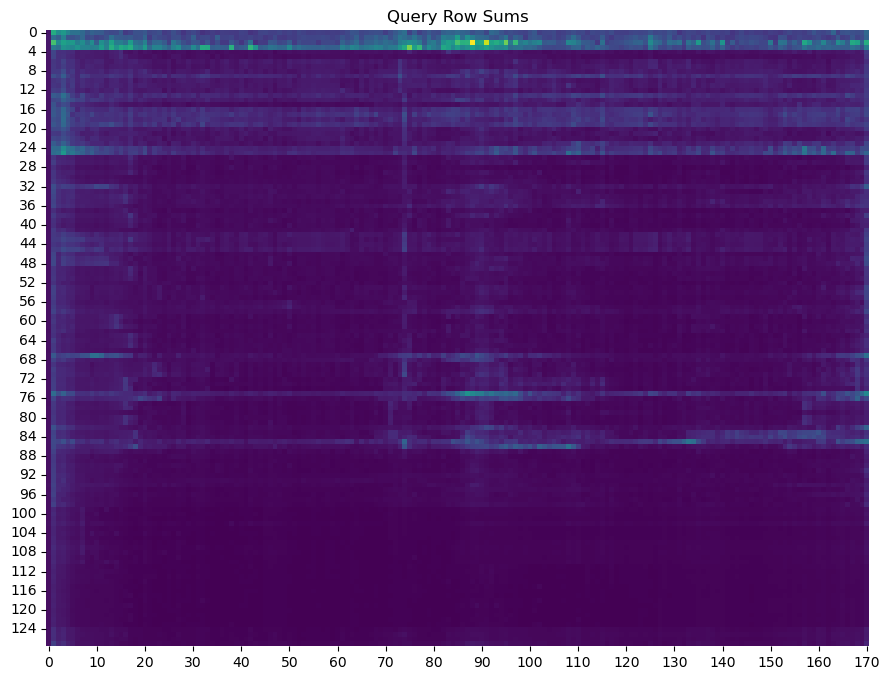

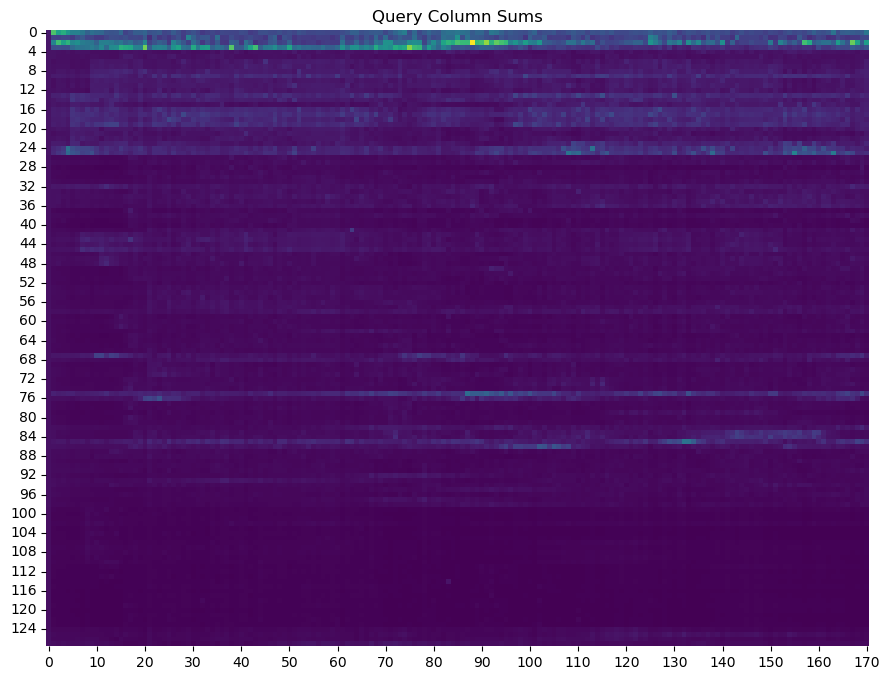

In [13]:
PDB_ID = pdb_id_9 + '_128'

query_stack = torch.load('../../data/query_col_attentions/query_col_attentions_' + PDB_ID + '.pt')
query_row = query_stack[1]
query_col = query_stack[0]
query_sums = query_col + query_row
print(query_sums.shape)


display_output_heatmap(query_sums, 'Query Sums')
display_output_heatmap(query_row, "Query Row Sums")
display_output_heatmap(query_col, "Query Column Sums")


3fhz_d


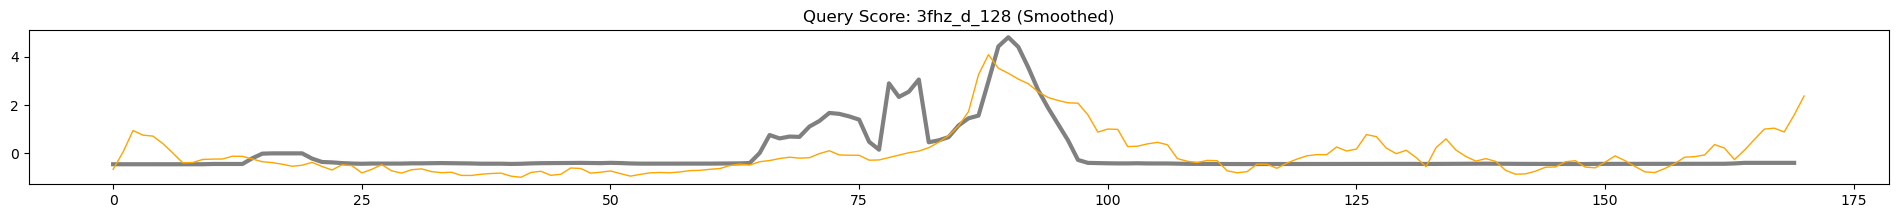

In [14]:
SELECT_INDEX = 75


pdb_name = PDB_ID.replace('_128', '')
print(pdb_name)
if df_rmsds['Unnamed: 0'].str.contains(pdb_name).sum() == 0:
    print("not found")
label_string = df_rmsds[df_rmsds['Unnamed: 0'].str.contains(pdb_name)].iloc[0, 1]
labels = normalise(literal_eval(label_string))


query_score = normalise(np.sum(query_sums[2:4], axis=0)[1:])

select_score = normalise(query_sums[SELECT_INDEX])


fig = plt.figure(figsize=(24, 2))
plt.plot(labels[0], lw=3, color='grey')
#plt.plot(smooth(query_score[0],5), lw=2, color='red')
plt.plot(smooth(select_score[0],2), lw=1, color='orange')

plt.title("Query Score: " + PDB_ID + " (Smoothed)")
plt.show()

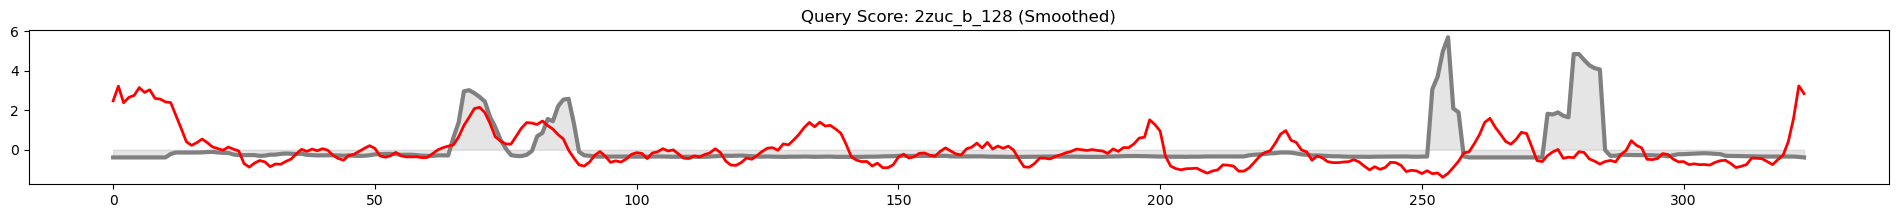

In [15]:
PDB_ID = '2zuc_b_128'

query_stack = torch.load('../../data/query_col_attentions/query_col_attentions_' + PDB_ID + '.pt')
query_row = query_stack[1]
query_col = query_stack[0]
query_sums = query_col + query_row

query_score = normalise(np.sum(query_sums, axis=0)[1:])
pdb_name = PDB_ID.replace('_128', '')

if df_rmsds['Unnamed: 0'].str.contains(pdb_name).sum() == 0:
    print("not found")
label_string = df_rmsds[df_rmsds['Unnamed: 0'].str.contains(pdb_name)].iloc[0, 1]
labels = normalise(literal_eval(label_string))

select_score = normalise(query_sums[SELECT_INDEX])

fig = plt.figure(figsize=(24, 2))
plt.plot(labels[0], lw=3, color='grey')
# Fill everything under the curve (including below 0)
plt.fill_between(range(len(labels[0])), labels[0], color='grey', alpha=0.2)
plt.plot(smooth(query_score[0],3), lw=2, color='red')
#plt.plot(smooth(select_score[0],2), lw=1, color='orange')

plt.title("Query Score: " + PDB_ID + " (Smoothed)")
plt.show()

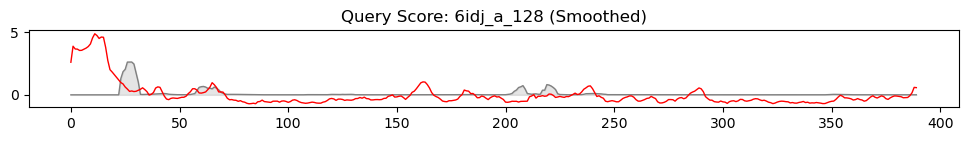

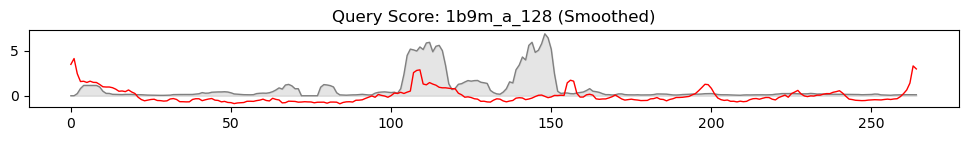

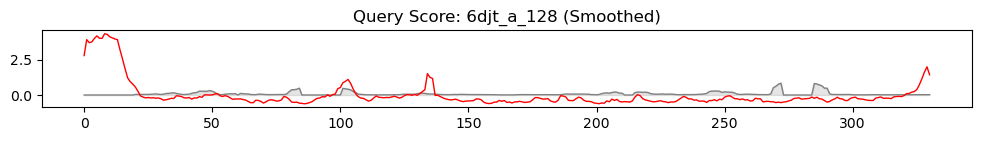

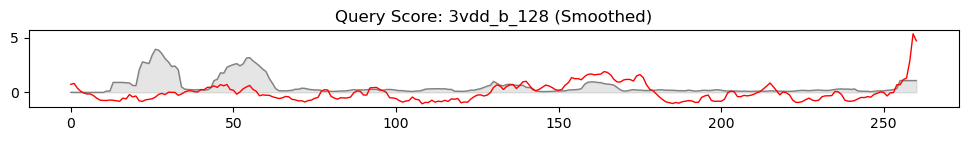

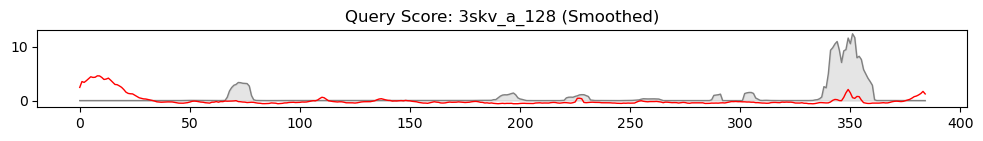

In [21]:
pdb_names = glob.glob('../../data/query_col_attentions/query_col_attentions_*.pt')
np.random.shuffle(pdb_names)

for i, pdb_name in enumerate(pdb_names):
    if i == 5:
        break
    ID = pdb_name.split('/')[-1].split('.')[0].replace('query_col_attentions_', '')
    query_stack = torch.load(pdb_name)
    query_row = query_stack[1]
    query_col = query_stack[0]
    query_sums = query_col + query_row

    query_score = normalise(np.sum(query_sums, axis=0)[1:])
    pdb_name = ID.replace('_128', '')

    if df_rmsds['Unnamed: 0'].str.contains(pdb_name).sum() == 0:
        print("not found")
        continue
    label_string = df_rmsds[df_rmsds['Unnamed: 0'].str.contains(pdb_name)].iloc[0, 1]
    labels = literal_eval(label_string)
    labels = np.reshape(labels, (1, len(labels)))
    #labels = normalise(literal_eval(label_string))

    select_score = normalise(query_sums[SELECT_INDEX])

    fig = plt.figure(figsize=(12, 1))
    plt.plot(labels[0], lw=1, color='grey')
    plt.fill_between(range(len(labels[0])), labels[0], color='grey', alpha=0.2)
    plt.plot(smooth(query_score[0],3), lw=1, color='red')
    #plt.plot(smooth(select_score[0],2), lw=1, color='orange')

    plt.title("Query Score: " + ID + " (Smoothed)")
    plt.show()